## ***Experiment 2: DirectionSplitSentiment***

### Install Necessary Libraries

In [ ]:
!pip install transformers
!pip install datasets
!pip install accelerate -U

# Restart Session
import os
os.kill(os.getpid(), 9)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 4.2 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 2.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-m

### Load the Google Drive into Colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import Libraries

In [2]:
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, Trainer, TrainingArguments, AdamW, TrainerCallback
from tqdm.notebook import tqdm  # Use notebook version of tqdm for better compatibility with Jupyter
from datetime import timedelta
from datasets import load_dataset
import plotly.graph_objects as go
from datasets import Dataset
from torch.utils.data import DataLoader, Dataset as torchDS
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from functools import partial
from scipy.special import softmax
import torch

### Load Dataset

In [2]:
import pandas as pd

In [3]:
df = pd.read_excel('/content/drive/MyDrive/st-data-full.xlsx')

In [4]:
df.to_csv('/content/drive/MyDrive/st-data-full.csv', index=False)

In [39]:
df[:1000].to_csv('/content/drive/MyDrive/test_direction_split_db.csv', index=False)

In [40]:
df = pd.read_csv('/content/drive/MyDrive/test_direction_split_db.csv')

In [41]:
df.head()

,text,label
0,"if you were curious, price chose the lowest ch...",1
1,"true, not even 10k followers here yet.",1
2,dogecoin co-founder billy markus hits back at ...,1
3,"i’m curious, do any bulls have a price where ...",1
4,friday everybody buy 10 more on friday,2


In [27]:
len(df)

1000

In [42]:
df['text']

0      if you were curious, price chose the lowest ch...
1                 true, not even 10k followers here yet.
2      dogecoin co-founder billy markus hits back at ...
3       i’m curious, do any bulls have a price where ...
4                 friday everybody buy 10 more on friday
                             ...                        
995                           gunning for a deleted zero
996                                        🐻 s nuts rn 🤣
997     major key support just hit could push over 49...
998                     don’t get fomo buy now before 67
999     cost of borrowing money getting more expensiv...
Name: text, Length: 1000, dtype: object

In [43]:
tweets_dataset = Dataset.from_pandas(df[['text', 'label']])

### Load Tokenizer and Tokenization

In [45]:
# Tokenize the text field in the dataset
def tokenize_function(tokenizer, examples):
    # Tokenize the text and return only the necessary fields
    encoded = tokenizer(examples["text"], padding='max_length', max_length=512)
    return {"input_ids": encoded["input_ids"], "attention_mask": encoded["attention_mask"], "label": examples["label"]}

In [46]:
# tokenizing the dataset text to be used in train and test loops
tokenizer = AutoTokenizer.from_pretrained("ElKulako/cryptobert")
partial_tokenize_function = partial(tokenize_function, tokenizer)

In [47]:
# Tokenize the text in the datasets
tokenized_dataset = tweets_dataset.map(partial_tokenize_function, batched=True)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [48]:
# Get a subset of the dataset for evaluation
tweets_dataset_subset = tokenized_dataset.select(range(100))

### Load the Models

In [49]:
base_model = AutoModelForSequenceClassification.from_pretrained("ElKulako/cryptobert", num_labels=3)

config.json:   0%|          | 0.00/932 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [ ]:
fine_tuned_model = AutoModelForSequenceClassification.from_pretrained("path_to_your_fine_tuned_model")

### Compute Metrics for Evaluation

In [50]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    probs = softmax(pred.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    roc_auc = roc_auc_score(labels, probs, multi_class='ovr')

    # Compute confusion matrix
    conf_matrix = confusion_matrix(labels, preds)

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Up', 'Neutral', 'Down'])
    disp.plot(cmap='Blues', values_format='d')
    plt.title('Confusion Matrix')
    plt.show()

    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'roc_auc': roc_auc,
        'confusion_matrix': conf_matrix
    }

## Evaluations

### The Base Model Evaluation

In [51]:
base_model_training_args = TrainingArguments(
    output_dir="../artifact"
)
base_model_trainer = Trainer(
    model=base_model,         # the non-fine-tuned model
    args=base_model_training_args,  # training arguments, defined above
    eval_dataset=tweets_dataset_subset,                # test dataset
    compute_metrics=compute_metrics,    # the compute_metrics function
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


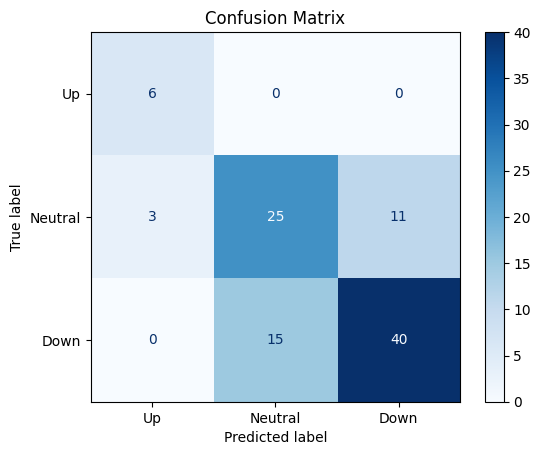

Trainer is attempting to log a value of "[[ 6  0  0]
 [ 3 25 11]
 [ 0 15 40]]" of type <class 'numpy.ndarray'> for key "eval/confusion_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


In [52]:
# Evaluate the model
base_model_eval_result = base_model_trainer.evaluate()

In [53]:
# Log metrics
for key, value in base_model_eval_result.items():
    print(key, value)

eval_loss 0.5907613635063171
eval_accuracy 0.71
eval_f1 0.7292094578457129
eval_precision 0.6919934640522875
eval_recall 0.7894327894327894
eval_roc_auc 0.8556088669691739
eval_confusion_matrix [[ 6  0  0]
 [ 3 25 11]
 [ 0 15 40]]
eval_runtime 4.4568
eval_samples_per_second 22.438
eval_steps_per_second 2.917


### The Fine-tuned Model Evaluation

In [ ]:
fine_tuned_model_training_args = TrainingArguments(
    output_dir="../artifact"
)
fine_tuned_model_trainer = Trainer(
    model=fine_tuned_model,         # the fine-tuned model
    args=fine_tuned_model_training_args,  # training arguments, defined above
    eval_dataset=tweets_dataset_subset,                # test dataset
    compute_metrics=compute_metrics,    # the compute_metrics function
)

In [ ]:
# Evaluate the model
fine_tuned_model_eval_result = fine_tuned_model_trainer.evaluate()

In [ ]:
# Log metrics
for key, value in fine_tuned_model_eval_result.items():
    print(key, value)

### Test

In [ ]:
def evaluate_model(model, tokenized_data):
    with torch.no_grad():
        input_ids = tokenized_data['input_ids']
        attention_mask = tokenized_data['attention_mask']
        labels = torch.tensor(df['label'].tolist())

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1)

    return predictions


In [ ]:
base_model_predictions = evaluate_model(model, tokenized_data)
fine_tuned_model_predictions = evaluate_model(fine_tuned_model, tokenized_data)

base_model_report = classification_report(df['label'], base_model_predictions)
fine_tuned_model_report = classification_report(df['label'], fine_tuned_model_predictions)

base_model_accuracy = accuracy_score(df['label'], base_model_predictions)
fine_tuned_model_accuracy = accuracy_score(df['label'], fine_tuned_model_predictions)

print("Base CryptoBERT Model Report:\n", base_model_report)
print("Fine-tuned CryptoBERT Model Report:\n", fine_tuned_model_report)

print("Base CryptoBERT Model Accuracy:", base_model_accuracy)
print("Fine-tuned CryptoBERT Model Accuracy:", fine_tuned_model_accuracy)


In [ ]:
def evaluate_model_with_trainer(model, tokenized_data, training_args):
    trainer = Trainer(
        model=model,
        args=training_args,
    )

    input_ids = tokenized_data['input_ids']
    attention_mask = tokenized_data['attention_mask']
    labels = torch.tensor(df['label'].tolist())

    eval_dataset = torch.utils.data.TensorDataset(input_ids, attention_mask, labels)

    result = trainer.evaluate(eval_dataset)
    return result


In [ ]:
training_args = TrainingArguments(
    per_device_eval_batch_size=8,   # Adjust batch size as needed
    logging_dir='./logs',
    report_to="none",  # Disable logging
)


In [ ]:
base_model_result = evaluate_model_with_trainer(model, tokenized_data, training_args)
fine_tuned_model_result = evaluate_model_with_trainer(fine_tuned_model, tokenized_data, training_args)

print("Base CryptoBERT Model Evaluation Result:\n", base_model_result)
print("Fine-tuned CryptoBERT Model Evaluation Result:\n", fine_tuned_model_result)
